In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import my_functions as mf


import os.path
from os import path

## Data Dictionary
We have pre-selected around 50,000 CpG sites stable methylation states. For each site, the following attributes are provided:

- CHR: CpG (chromosome number)
- MAPINFO: CpG Location (base location on the chromosome)
- UCSC_CpG_Islands_Name: CpG island information - Chromosomal coordinates of the CpG Island from UCSC.
- UCSC_RefGene_Group: CpG position relative to genes
- Relation_to_UCSC_CpG_Island: CpG position relative to CpG islands
- Regulatory_Feature_Group: CpG position relative to regulatory elements
- Forward_Sequence: DNA sequence surrounding the CpG (~120 bases)
- seq: DNA sequence surrounding the CpG (~2000 bases)
- Beta: CpG methylation state: (0= unmethylated, 1=methylated)

See the train (~30,000 observations) and test (20,000 observations) data

---
#### Relation_to_UCSC_CpG_Island: CpG position relative to CpG islands:


    - Shore = 0–2 kb from island.
    - Shelf = 2–4 kb from island.
    - N = upstream (5’) of CpG island.
    - S = downstream (3’) of CpG island.


	• Island
	• nan
	• S_Shore
	• N_Shelf
	• N_Shore 
	• S_Shelf

---
### Regulatory_Feature_Group: CpG position relative to regulatory elements:

	• nan
	• Promoter_Associated
	• Unclassified
	• Gene_Associated
	• Unclassified_Cell_type_specific
	• Promoter_Associated_Cell_type_specific
	• NonGene_Associated
	• Gene_Associated_Cell_type_specific
	• NonGene_Associated_Cell_type_specific

---
### UCSC_RefGene_Group: CpG position relative to genes(Every instance might have more than one of the following unique values):

	•Body = Between the ATG and stop codon; irrespective of the presence of introns, exons, TSS, or promoters.
	•TSS200 = 0–200 bases upstream of the transcriptional start site (TSS).
	•5'UTR = 5'UTR = Within the 5' untranslated region, between the TSS and the ATG start site.
	•1stExon
	•nan
	•TSS1500 = TSS1500 = 200–1500 bases upstream of the TSS.
	•3'UTR = 3'UTR = Between the stop codon and poly A signal.
---

In [ ]:
##################### reading the dataframe #####################
long = True  # turn it to false for short dataset instead of long 
file_name = 'train.csv'

df = pd.read_csv(file_name)

if long:
    file_name = 'long_train.csv'
else:
    file_name = 'train.csv'
    
if not path.exists("GCF_000001405.39_GRCh38.p13_assembly_stats.txt"):
    !wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.39_GRCh38.p13/GCF_000001405.39_GRCh38.p13_assembly_stats.txt
        
GRCh38_p13_assembly_stats = pd.read_csv('GCF_000001405.39_GRCh38.p13_assembly_stats.txt', header = 85, delimiter = '\t')
#################################################################

##################### one hot-coding #####################
# features to be tranformed to one hot coding format
features = ['UCSC_RefGene_Group', 'Regulatory_Feature_Group', 'Relation_to_UCSC_CpG_Island']

# column that you don't want to be included in the counting process (replace this with zeros in the other columns)
excludings = ['nan', 'nan', 'nan']

for feature, excluding in zip(features, excludings):
    df = mf.column_to_hot_coding(df, feature, ex = 'nan')

# delete existing columns in the previous "compact" format
df = df.drop(labels = features, axis = 1)
##########################################################

##################### extracting features directly from sequences #####################
com = [''.join(s) for s in itertools.product(['A', 'C', 'G', 'T'], repeat=4)]

Cs = df['seq'].apply(lambda x:x.count('C'))
Gs = df['seq'].apply(lambda x:x.count('G'))
l = df['seq'].apply(lambda x:len(x))

df['observed_ratio'] = df['seq'].apply(lambda x:x.count('CG')) #number of CpGs
df['expected_ratio'] = Cs * Gs / l
df['expected_ratio_test'] = pow((Cs * Gs / 2), 2) / l

df['observed_to_expected_ratio'] = df['observed_ratio'] / df['expected_ratio']

if long:
    for i in range(len(com)):
        df[com[i]] = df['seq'].apply(lambda x:x.count(com[i]))

df['Is-GC'] = [ratio > 0.6 for ratio in df['observed_to_expected_ratio']]
#######################################################################################

##################### percentage position calculation based on chromosomes of GRCh38.p13 #####################
df['UCSC_CpG_Islands_Name'] = df['UCSC_CpG_Islands_Name'].apply(lambda x : mf.split(x, ':', 1))

used_chromosomes = [str(x) for x in df['CHR'].unique().tolist()]

test = GRCh38_p13_assembly_stats[(GRCh38_p13_assembly_stats['# unit-name'] == 'Primary Assembly') & 
                          (GRCh38_p13_assembly_stats['sequence-type'] == 'assembled-molecule') &
                          (GRCh38_p13_assembly_stats['statistic'] == 'total-length')][['molecule-name', 'value']].loc[GRCh38_p13_assembly_stats['molecule-name'].isin(used_chromosomes)]

chromosomes_lengths = pd.Series(test['value'].values,index=test['molecule-name']).to_dict()

def is_in(num, a, b):
    num = int(num)
    if num <= b:
        return True
    else:
        return False

# df['percentage_pos'] = df[['MAPINFO','CHR']].apply(lambda x : x.MAPINFO / end[x.CHR - 1], axis=1)
df['percentage_pos'] = df[['MAPINFO','CHR']].apply(lambda x : x.MAPINFO / chromosomes_lengths[str(x.CHR)], axis=1)

# a small report about the instances that are beyong the ending coordinate of the corresponding chromosome
t = df[df['percentage_pos'] > 1]['percentage_pos']-1
# t = df[['MAPINFO','CHR']].apply(lambda x : is_in(x.MAPINFO, start[x.CHR-1], end[x.CHR-1]), axis=1)
t.describe()
##############################################################################################################

##################### dropping some features and balance the set (extra dataframe is used) #####################
df = df.drop(labels = ['Id', 'CHR', 'MAPINFO', 'UCSC_CpG_Islands_Name'], axis = 1)

# Balancing by random under-sampling
df_class_0 = df[df['Beta'] == 0]
df_class_1 = df[df['Beta'] == 1]

class_counts = df.Beta.value_counts()
num = min(class_counts)

df_class_0_under = df_class_0.sample(num)
df_class_1_under = df_class_1.sample(num)

df_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)
################################################################################################################

##################### write the balanced and the original data frames into separate csv files #####################
df.to_csv('processed_' + file_name, index = False)
df_under.to_csv('processed_balanced_' + file_name, index = False)
###################################################################################################################

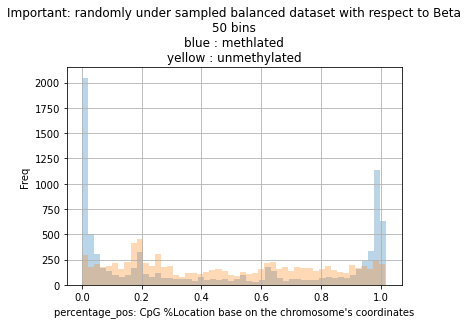

In [ ]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=50)

plt.hist(df_under[df_under['Beta'] == True]['percentage_pos'],  **kwargs)
plt.hist(df_under[df_under['Beta'] == False]['percentage_pos'], **kwargs)

plt.xlabel("percentage_pos: CpG %Location base on the chromosome's coordinates")
plt.ylabel('Freq')
plt.title('Important: randomly under sampled balanced dataset with respect to Beta\n50 bins\nblue : methlated\nyellow : unmethylated')
plt.grid(True)

Average number of GC occurrence (methylated):  62.85309453638631
Average number of GC occurrence (unmethylated):  116.63341645885286


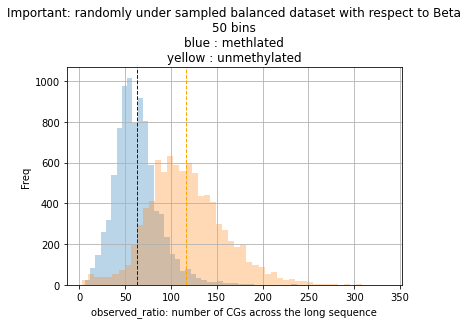

In [ ]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=50)

plt.hist(df_under[df_under['Beta'] == True]['observed_ratio'],  **kwargs)
plt.hist(df_under[df_under['Beta'] == False]['observed_ratio'], **kwargs)

plt.xlabel("observed_ratio: number of CGs across the long sequence")
plt.ylabel('Freq')
plt.title('Important: randomly under sampled balanced dataset with respect to Beta\n50 bins\nblue : methlated\nyellow : unmethylated')
plt.grid(True)

plt.axvline(df_under[df_under['Beta'] == True]['observed_ratio'].mean(), color='b', linestyle='dashed', linewidth=1)
plt.axvline(df_under[df_under['Beta'] == False]['observed_ratio'].mean(), color='orange', linestyle='dashed', linewidth=1)


print('Average number of GC occurrence (methylated): ', np.mean(df_under[df_under['Beta'] == True]['observed_ratio']))

print('Average number of GC occurrence (unmethylated): ', np.mean(df_under[df_under['Beta'] == False]['observed_ratio']))

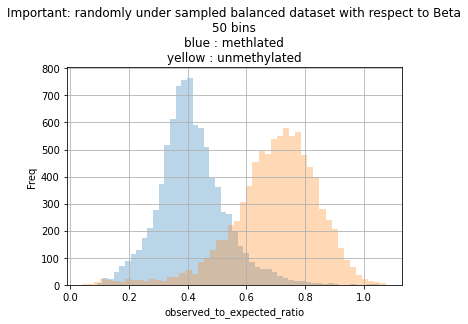

In [ ]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=50)

plt.hist(df_under[df_under['Beta'] == True]['observed_to_expected_ratio'],  **kwargs)
plt.hist(df_under[df_under['Beta'] == False]['observed_to_expected_ratio'], **kwargs)

plt.xlabel("observed_to_expected_ratio")
plt.ylabel('Freq')
plt.title('Important: randomly under sampled balanced dataset with respect to Beta\n50 bins\nblue : methlated\nyellow : unmethylated')
plt.grid(True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddf6b85a-936f-43e7-bfb4-c1fea12493a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>